In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
data = yf.download(['AMZN', 'AAPL', '^GSPC'], start='2018-01-01', end='2020-06-01')['Adj Close']
data

[*********************100%%**********************]  3 of 3 completed


,AAPL,AMZN,^GSPC
Date,,,
2018-01-02,40.722878,59.450500,2695.810059
2018-01-03,40.715786,60.209999,2713.060059
2018-01-04,40.904903,60.479500,2723.989990
2018-01-05,41.370613,61.457001,2743.149902
2018-01-08,41.216961,62.343498,2747.709961
...,...,...,...
2020-05-22,78.063301,121.844002,2955.449951
2020-05-26,77.534531,121.093002,2991.770020
2020-05-27,77.872353,120.519501,3036.129883


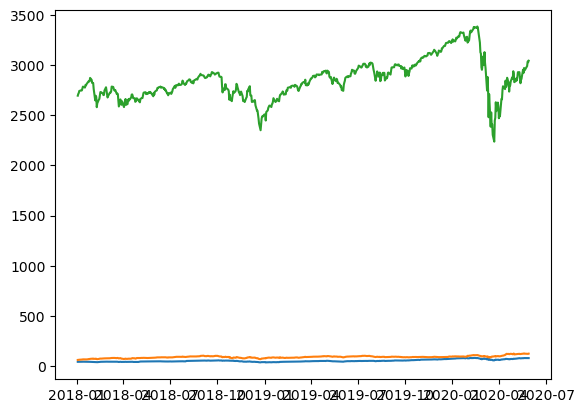

In [22]:
plt.plot(data)

In [23]:
def computeBeta(data, stock, market):
    rets = np.log(data / data.shift(1))
    cov = rets.cov() * 252
    covWmarket = cov.loc[stock, market]
    marketVar = rets[market].var() * 252
    return covWmarket / marketVar
    
def computeCAPM(data, stock, market, riskFree = .025, riskPremium = 'market'):
    rets = np.log(data / data.shift(1))
    
    if riskPremium == 'market':
        riskPremium = (rets[market].mean() * 252) - riskFree
    beta = computeBeta(data, stock, market)
    return riskFree + beta * riskPremium

def computeSharpe(data, stock, market, riskFree = .025, riskPremium = 'market'):
    rets = np.log(data / data.shift(1))
    ret = computeCAPM(data, stock, market, riskFree = .025, riskPremium = 'market')
    return (ret - riskFree) / (rets[stock].std() * 252 ** .5)

def stockCAPM(data, stock, market, riskFree = .025, riskPremium = 'market'):
    beta = computeBeta(data, stock, market)
    capm = computeCAPM(data, stock, market, riskFree, riskPremium)
    sharpe = computeSharpe(data, stock, market, riskFree, riskPremium)
    
    capmData = pd.DataFrame([beta, capm, sharpe], columns=[stock], index=['Beta', 'CAPM', 'Sharpe'])
    return capmData.T

In [24]:
stockCAPM(data, 'AMZN', '^GSPC')

,Beta,CAPM,Sharpe
AMZN,0.875965,0.04746,0.068663


In [25]:
stockCAPM(data, 'AAPL', '^GSPC')

,Beta,CAPM,Sharpe
AAPL,1.158994,0.054716,0.086696


In [26]:
import pypfopt

In [27]:
pypfopt.expected_returns.capm_return(data[['AAPL', 'AMZN']], data['^GSPC'])

/home/tea/.var/app/org.jupyter.JupyterLab/config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/pypfopt/expected_returns.py:254: RuntimeWarning: market prices are not in a dataframe
  warnings.warn("market prices are not in a dataframe", RuntimeWarning)


AAPL    0.057118
AMZN    0.048094
Name: mkt, dtype: float64

In [28]:
S = pypfopt.risk_models.risk_matrix(data)
S

,AAPL,AMZN,^GSPC
AAPL,0.116845,0.071865,0.068800
AMZN,0.071865,0.106901,0.052074
^GSPC,0.068800,0.052074,0.059210


In [29]:
np.sqrt(S)

,AAPL,AMZN,^GSPC
AAPL,0.341826,0.268076,0.262297
AMZN,0.268076,0.326957,0.228197
^GSPC,0.262297,0.228197,0.243331


In [33]:
mu = pypfopt.expected_returns.mean_historical_return(data)
mu

AAPL     0.309709
AMZN     0.349639
^GSPC    0.051944
dtype: float64

In [44]:
portf = pypfopt.EfficientFrontier(pypfopt.expected_returns.mean_historical_return(data[['AMZN', 'AAPL']]),
                                  pypfopt.risk_models.risk_matrix(data[['AMZN', 'AAPL']]))

In [46]:
portf.max_sharpe()

OrderedDict([('AMZN', 0.7085098435762444), ('AAPL', 0.2914901564237557)])

In [47]:
portfP = portf.portfolio_performance(verbose=True)

Expected annual return: 33.8%
Annual volatility: 30.5%
Sharpe Ratio: 1.04


In [53]:
sigmaM = np.sqrt(S.to_numpy())[2,2]
sigmaM

0.24333088776237882

In [54]:
muM = mu['^GSPC']
muM

0.05194384731567725

In [ ]:
capm = portfP[0] + ((portP[1] / sigmaM) * ())